# Check tightness in real data

In [1]:
import logging
import os
import os.path as osp
import pickle
from matplotlib.pyplot import xscale

import networkx as nx
import numpy as np
from ogw.gromov_prox import projection_matrix
from ogw.gw_lb import tlb
from ogw.gwtil import eval_gwtil_ub, gwtil_lb, gwtil_ub
from ogw.utils import load_pyg_data
from joblib.parallel import Parallel, delayed
from ot.gromov import gromov_wasserstein
from torch_geometric.datasets import TUDataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
logging.basicConfig(format='%(asctime)s - %(message)s ', level=logging.INFO)

In [2]:
# replace your ROOT path
ROOT = osp.join(osp.expanduser("~"), 'tmp', 'data', "TUDataset")
dsname = "MUTAG"

# prepare dataset
Gs, ys = load_pyg_data(dsname)
Cs = [nx.floyd_warshall_numpy(g) for g in Gs]
Ns = [C.shape[0] for C in Cs]
ps = [np.ones(n) / n for n in Ns]

SAVED_PATH = osp.join(ROOT, dsname, "saved")
if not osp.isdir(SAVED_PATH):
    logging.info("creating folder")
    os.makedirs(SAVED_PATH)

N = len(Gs)




In [3]:
# calculate pairwise distance in parallel

def calc_D_GW(i, j, D):
    T, gw_log = gromov_wasserstein(Cs[i], Cs[j], ps[i], ps[j], loss_fun="square_loss", log=True)
    D[i, j] = gw_log['gw_dist']


def calc_D_GW_lb(i, j, D):
    D[i, j] = tlb(Cs[i], Cs[j])


def calc_D_OGW_lb(i, j, D):
    D[i, j] = gwtil_lb(Cs[i], Cs[j])


def calc_D_OGW_ub(i, j, D):
    D[i, j] = gwtil_ub(Cs[i], Cs[j])


# GW
fn_mm = osp.join(ROOT, dsname, "D_GW")
D_GW = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

logging.info(f"calcualte GW")
Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(calc_D_GW)(i, j, D_GW) for i in range(N) for j in range(i + 1, N))
D_GW += D_GW.T

pickle.dump(D_GW, open(osp.join(SAVED_PATH, "D_GW.pkl"), "wb"))

# GW_lb
fn_mm = osp.join(ROOT, dsname, "D_GW_lb")
D_GW_lb = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

logging.info(f"calcualte GW_lb")
Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(calc_D_GW_lb)(i, j, D_GW_lb) for i in range(N) for j in range(i + 1, N))
D_GW_lb += D_GW_lb.T

pickle.dump(D_GW_lb, open(osp.join(SAVED_PATH, "D_GW_lb.pkl"), "wb"))

# OGW_lb
fn_mm = osp.join(ROOT, dsname, "D_OGW_lb")
D_OGW_lb = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

logging.info(f"calcualte OGW_lb")
Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(calc_D_OGW_lb)(i, j, D_OGW_lb) for i in range(N) for j in range(i + 1, N))
D_OGW_lb += D_OGW_lb.T

pickle.dump(D_OGW_lb, open(osp.join(SAVED_PATH, "D_OGW_lb.pkl"), "wb"))

# OGW_ub
fn_mm = osp.join(ROOT, dsname, "D_OGW_ub")
D_OGW_ub = np.memmap(fn_mm, mode="w+", shape=(N, N), dtype=float)

logging.info(f"calcualte OGW_ub")
Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(calc_D_OGW_ub)(i, j, D_OGW_ub) for i in range(N) for j in range(i + 1, N))
D_OGW_ub += D_OGW_ub.T

pickle.dump(D_OGW_ub, open(osp.join(SAVED_PATH, "D_OGW_ub.pkl"), "wb"))


2022-02-28 00:52:27,531 - calcualte GW 
/home/hjin/miniconda3/envs/ogw/lib/python3.7/site-packages/ot/optim.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/home/hjin/miniconda3/envs/ogw/lib/python3.7/site-packages/ot/optim.py:305: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/home/hjin/miniconda3/envs/ogw/lib/python3.7/site-packages/ot/optim.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/home/hjin/miniconda3/envs/ogw/lib/python3.7/site-packages/ot/optim.py:305: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/home/hjin/miniconda3/envs/ogw/lib/python3.7/site-packages/ot/optim.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)
/home/hjin/minico

Text(0, 0.5, 'Density')

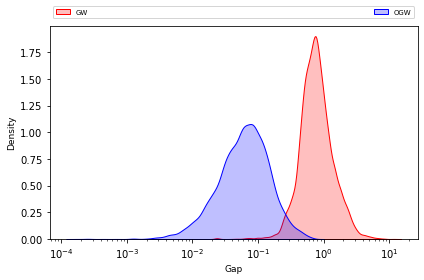

In [4]:
# plot
GW_diff = np.abs(np.triu(D_GW - D_GW_lb, k=1))
OGW_diff = np.abs(np.triu(D_OGW_ub - D_OGW_lb, k=1))

fig = plt.figure(tight_layout=True)
sns.kdeplot(GW_diff[GW_diff > 1e-4].flatten(), shade=True, color="r", label="GW", log_scale=True)
sns.kdeplot(OGW_diff[OGW_diff > 1e-4].flatten(), shade=True, color="b", label="OGW", log_scale=True)

plt.legend(loc="lower left",
           ncol=2,
           prop={'size': 7},
           bbox_to_anchor=(0., 1.02, 1., .2),
           mode="expand")
plt.xlabel("Gap", fontsize=9)
plt.ylabel("Density", fontsize=9)
